## Import

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
from time import perf_counter
import glob
import json
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import figure
%autosave 3600

Autosaving every 3600 seconds


# Indice

- [Score study](#score_s)
- [Distribution of CAP score](#cap_score)
- [Bot study](#bot_study)
- [Bot distribution](#bot_d)
- [Bot category](#bot_c)
- [Utils](#utils)

In [2]:
path = glob.glob('C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored/*.json')
path

['C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_original_1.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_original_2.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_replied_1.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_replied_2.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_reply_1.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_reply_2.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_retweeted_1.json',
 'C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/json_scored\\score_results_retweet_1.json']

## Score study
<a id='score_s'></a>

In [3]:
def convert(list):
    return tuple(list)

In [4]:
def calculate_scores(data):
    list_score = []
    value_error = 0
    for i in data:
        obj = data[i]
        scores = obj["scores"]
        if((scores is None) or ("error" in scores)):
            value_error = value_error + 1
        else:
            cap = scores["cap"]
            eng_score = cap["english"]
            list_score.append(eng_score)
    print(f"Errors: {value_error}")
    return list_score

In [5]:
def type_of_bot(merged_json, i):
    x = merged_json[i]['scores']['raw_scores']['english']
    x.pop('overall')
    list_raws = list(x.keys())
    value = 0
    index = ""
    for j in list_raws:
        if x[j] >= value:
            value = x[j]
            index = j
    return (merged_json[i]["screen_name"], index)

In [6]:
num_err = 0
list_human = []
list_bot = []
bot_type = []
error_list = []
file_score = []

In [7]:
for i in range(len(path)):
    value = open(path[i],)
    data = json.load(value)
    value.close()
    if i == 0:
        merged_json = data
    else:
        merged_json.update(data)
        
box = calculate_scores(merged_json)

Errors: 35026


### Distribution of CAP score
<a id="cap_score"/>

In [8]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

[0.3912159239072283, 0.6414184221423734, 0.7920317685697057, 0.8076035454448582, 0.8670116134145492]


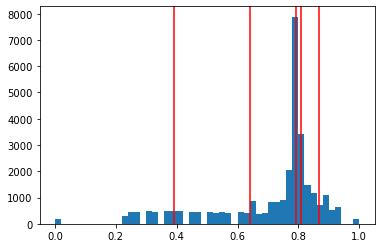

In [9]:
index = [10, 25, 50, 75, 90]
perc_numpy = [np.percentile(box, i, interpolation='nearest') for i in index]
print(perc_numpy)
treshold_human = perc_numpy[0] 
treshold_bot = perc_numpy[4]
# # Plotting
plt.hist(box, 50)
for i in range(len(index)):
    plt.axvline(perc_numpy[i], color='r')
plt.show()

In [16]:
# fig = px.histogram(box, title="Distribution of CAP score")
# fig.show()

In [17]:
# fig = px.box(box, title="Boxplt CAP score")
# fig.show()

### Bot study
<a id="bot_study"/>

In [12]:
for i in merged_json:
    obj = merged_json[i]
    id_user = obj["id"]
    screen_name = obj["screen_name"]
    scores = obj["scores"]
    if((scores is None) or ("error" in scores)):
        error_list.append((scores, i))
    else:
        cap = scores["cap"]
        eng_score = cap["english"]
        file_score.append((screen_name, eng_score))
        if(eng_score <= treshold_human):
            list_human.append((id_user, screen_name))
        elif(eng_score >= treshold_bot):
            list_bot.append((id_user, screen_name))
            bot_type.append(type_of_bot(merged_json, i))

In [13]:
len(file_score)

30616

### Bot distribution
<a id='bot_d'></a>

In [14]:
total_users = len(merged_json)
total_bots = len(list_bot)
total_human = len(list_human)
print(f'Number of total users: {total_users}')
print(f'Number of bots: {total_bots}')
print(f'Number of person: {total_human}')

perc_bot = np.around(total_bots*100/total_users,2)
perc_person = np.around(total_human*100/total_users,2)
print(f'Perc of bots: {perc_bot}% of total users')
print(f'Perc of person: {perc_person}% of total users')

Number of total users: 65642
Number of bots: 3151
Number of person: 3274
Perc of bots: 4.8% of total users
Perc of person: 4.99% of total users


### Bot category
<a id='bot_c'></a>

#### Categorie:
- cap: probabilità condizionale che un utente con un punteggio maggiore o uguale a questo sia automatizzato (sia nella lingua dell'utente che in inglese)
- display scores: come raw score ma con un range che va da [0,5]
- raw scores: bot score con range che va da [0,1], sia in inglese che nella lingua dell'utente, contiene sottocategorie
- user: Utente Twitter con informazioni sull'id, nome e lingua dedotta dalla maggioranza dei tweet

#### Sottocategorie:
- fake_follower: bot acquistati per aumentare il numero di follower
- self_declared: bot da botwiki.org
- astroturf: bot politici etichettati manualmente e account coinvolti in follow trains che cancellano sistematicamente i propri contenuti
- spammer: account etichettati come spambot
- financial: bot che usando i cashtag
- other: vari altri bot ottenuti da annotazioni manuali, feedback degli utenti, ecc.



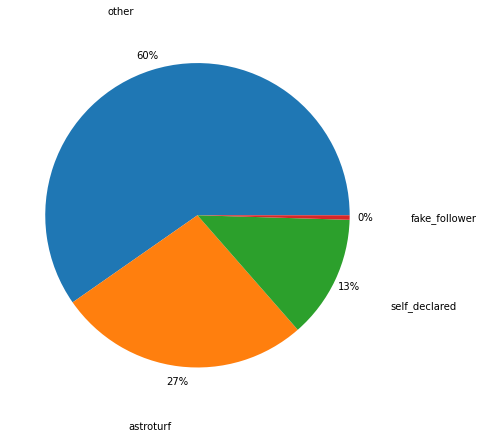

In [15]:
plot = []
for i in range(len(bot_type)):
    plot.append(bot_type[i][1])
a = pd.Series(plot).value_counts().sort_values(ascending=False)
plot = a.plot.pie(autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.4, label="", figsize=(7, 7))

In [54]:
df_bot = pd.DataFrame(list_bot, columns =['id','user'])
df_bot

,id,user
0,1252818873578975232,matomecorona
1,1239490346691760128,Host24Space
2,1238684966063501313,CoronaVirusNFO
3,1203462567861084160,naija_reports
4,1245483551749005312,FR24NewsFrance
...,...,...
3146,2937491779,MARIASILVIAARM2
3147,2459302512,mickivoss
3148,1088122630471847937,Diana_Chumley
3149,1021753060585078789,hushnowlilbaby


In [55]:
df_score = pd.DataFrame(file_score, columns =['user','score'])
df_score

,user,score
0,matomecorona,0.930754
1,TomthunkitsMind,0.796637
2,Host24Space,0.937364
3,CoronaVirusNFO,0.899551
4,Dooiz1,0.799836
...,...,...
30611,claudiapoindex2,0.937364
30612,kitty201718,0.775989
30613,hauntedpixie1,0.785221
30614,foxylad95283351,0.705338


In [56]:
path = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/")
df_bot.to_csv(path[0] + "csv/bot_score.csv", index=False)
df_score.to_csv(path[0] + "large_files/user_score.csv", index=False)

# Utils
<a id='utils'></a>

### Split csv into small subfiles

In [ ]:
path_split = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/*.csv")

df = pd.read_csv(path_split[3])
file_len = len(df)
outputname = "retweet" 
filename = 'C:/Users/Gianluca/Desktop/provascript/' + str(outputname)
n = 1
dim = 2500
for i in range(file_len):
    if i % dim == 0:
        sf = (df[i:i+dim])
        sf.to_csv(f'{filename}_{n}.csv', index=False)
        n += 1

In [ ]:
def split_csv(name, dim, outputname):
    path_split = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/*.csv")
    for i in range(len(path_split)):
        if name in path_split[i]:
            df = pd.read_csv(path_split[i])
    file_len = len(df)
    filename = 'C:/Users/Gianluca/Desktop/provascript/' + str(outputname)
    n = 1
    for i in range(file_len):
        if i % dim == 0:
            sf = (df[i:i+dim])
            sf.to_csv(f'{filename}_{n}.csv', index=False)
            n += 1